# Add Protein to RNA cite seq data

In [1]:
import os
import sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
import rpy2
import seaborn as sns
import scipy
import anndata
from scipy.sparse import csr_matrix
import harmonypy as hm
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, dpi_save=1000)

In [2]:
protein_path = '/nfs/team205/ig7/resources/scripts_dont_modify/cite_seq/Objects_for_bertie_meeting_14102021/protein_temp_object_12102021.h5ad'
rna_path = '/nfs/team205/ig7/resources/scripts_dont_modify/cite_seq/Objects_for_bertie_meeting_14102021/cite_seq_object_new_doublets_removed_20211001.h5ad'
batch_correction = "Harmony"
batch_var = 'identifier'

# Load in Protein data

In [3]:
#protein = sc.read(protein_path)
protein = sc.read('/nfs/team205/ig7/resources/scripts_dont_modify/cite_seq/Objects_for_bertie_meeting_14102021/protein_processed.h5ad')
# Rename Protein var_names to make unique classes
protein.var['protein_var'] = protein.var.index
protein.var['feature_types'] = 'protein'
protein.obs.columns = protein.obs.columns.astype(str) + '_protein'
protein.var.index = protein.var.index.astype(str) + '_protein'
protein_meta = pd.read_csv('/nfs/team205/ig7/resources/scripts_dont_modify/cite_seq/protein_object_progen_anno_13102021.csv',index_col = 0)

In [4]:
#protein.X = protein.raw.X

In [5]:
#protein = protein[protein.obs.index.isin(protein_meta.index)]
#protein.obsm["X_umap"] = protein_meta[['X_UMAP_1','X_UMAP_2']]
#protein.obs = protein_meta

In [6]:
#protein.write(protein_path)

# Load in rna data

In [7]:
rna = sc.read(rna_path)
rna.obs['new_index'] = rna.obs.index.str.replace('-1-SIGAG5-SIGAG5','-SIGAD11',regex=True)
rna.obs['new_index'] = rna.obs['new_index'].str.replace('-1-SIGAH5-SIGAH5','-SIGAE11',regex=True)
rna.obs.index = rna.obs['new_index']
del rna.obs['new_index']
rna.obs.index.name = ''

# Creation of combination data

In [8]:
protein.X

array([[-0.18323259, -0.13993521, -0.06476734, ..., -0.13369139,
         0.5704069 , -0.07121325],
       [-0.18323259, -0.13993521, -0.06476734, ...,  0.44215056,
        -0.09906582, -0.07121325],
       [ 0.8405568 , -0.13993521, -0.06476734, ..., -0.13369139,
         0.24963424,  1.003877  ],
       ...,
       [ 1.7752026 ,  1.7397858 ,  1.8769122 , ...,  0.96785265,
         1.6454816 , -0.07121325],
       [-0.18323259, -0.13993521, -0.06476734, ..., -0.13369139,
        -0.48102382, -0.07121325],
       [-0.18323259,  1.7397858 , -0.06476734, ...,  2.7059603 ,
         1.8745457 ,  1.9128532 ]], dtype=float32)

In [13]:
# Each data should be normalised/scaled to itsel prior to concatenation
protein = protein[protein.obs.index.isin(rna.obs.index)]
rna = rna[rna.obs.index.isin(protein.obs.index)]

# Ordering the protein data to the rna data
protein.obs['ordering'] = list(range(0,len(protein.obs)))
protein.obs = protein.obs.reindex(list(rna.obs.index))
order = protein.obs['ordering']
protein.X = protein.X[order]

protein_obs = protein.obs
print(len(rna.obs))
exp_arr = csr_matrix(scipy.sparse.hstack(((rna.X),(protein.X))))
var = pd.concat([rna.var,protein.var])
obs = pd.concat([rna.obs, protein_obs], axis=1)
uns = rna.uns
obsm = rna.obsm
#varm = rna.varm
obsp = rna.obsp
adata = anndata.AnnData(X=exp_arr, obs=obs, var=var, uns=uns, obsm=obsm, varm=None, layers=None, raw=None, dtype='float32', shape=None, filename=None, filemode=None, asview=False, obsp=obsp, varp=None, oidx=None, vidx=None)
adata.obsm['X_umap_rna'] = rna.obsm['X_umap']

Trying to set attribute `.obs` of view, copying.


3569


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


    using 'X_pca' with n_pcs = 45
Storing dendrogram info using `.uns['dendrogram_work_labels_with_progen_labels_13102021_protein']`


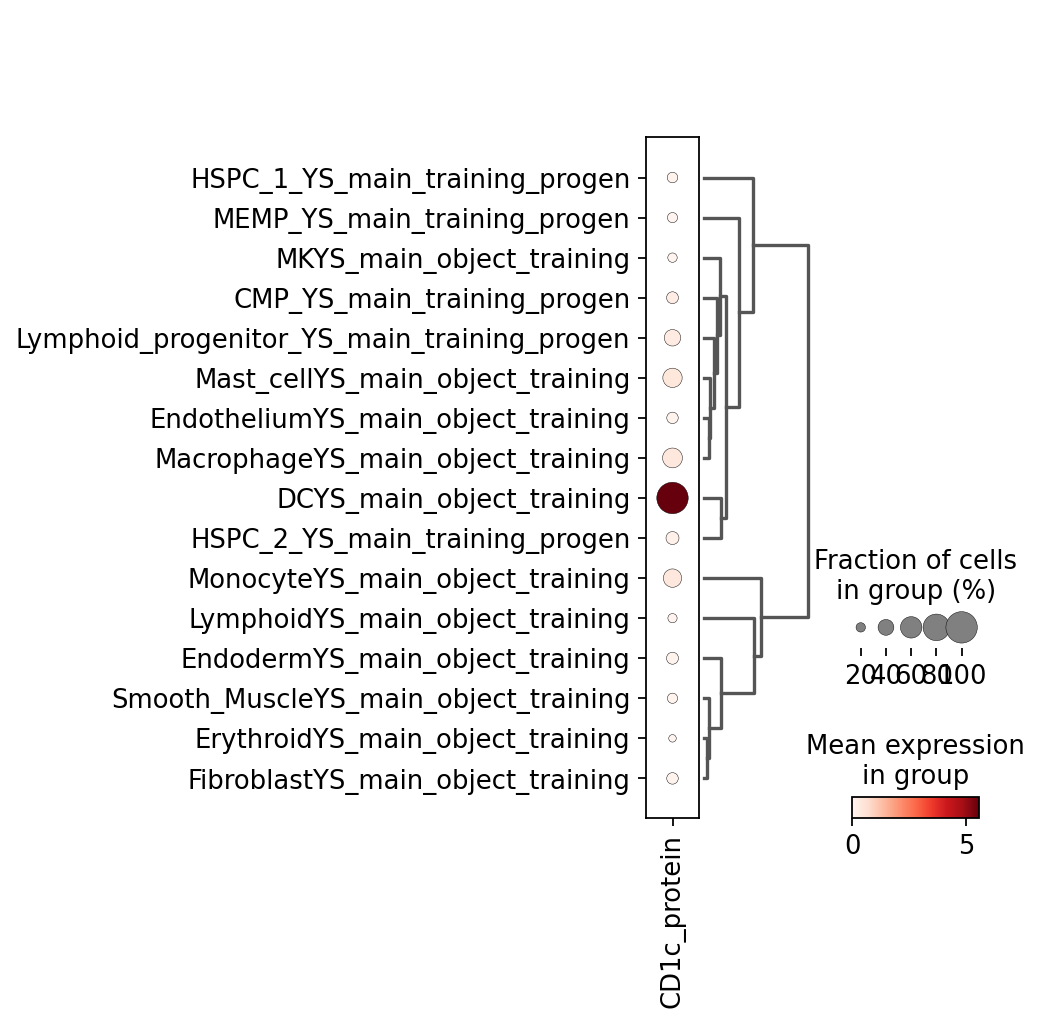

In [14]:
markers = ['CD1c_protein']
sc.pl.dotplot(protein, markers, groupby='work_labels_with_progen_labels_13102021_protein', dendrogram=True,use_raw=False)

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'gene_ids' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated

    using 'X_pca' with n_pcs = 100
Storing dendrogram info using `.uns['dendrogram_work_labels_with_progen_labels_13102021_protein']`


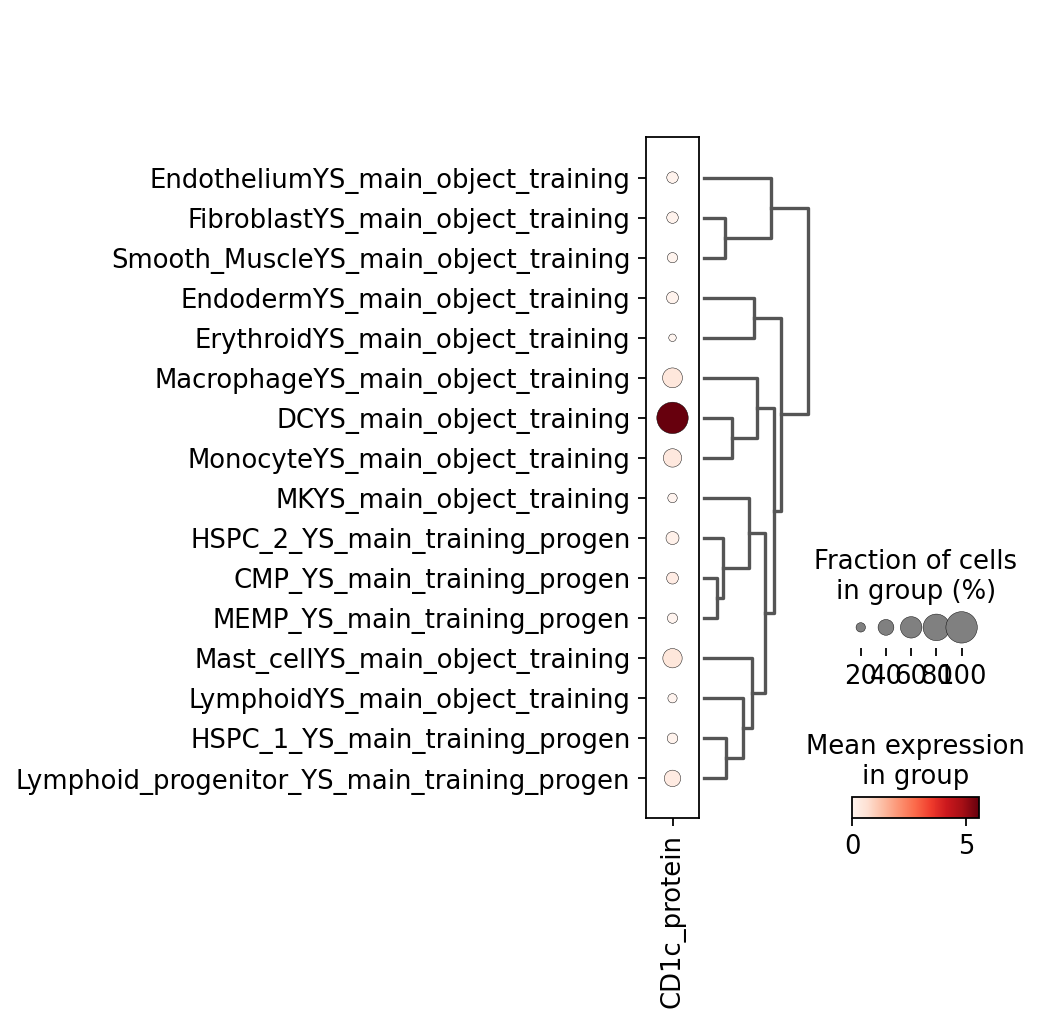

In [15]:
markers = ['CD1c_protein']
sc.pl.dotplot(adata, markers, groupby='work_labels_with_progen_labels_13102021_protein', dendrogram=True,use_raw=False)

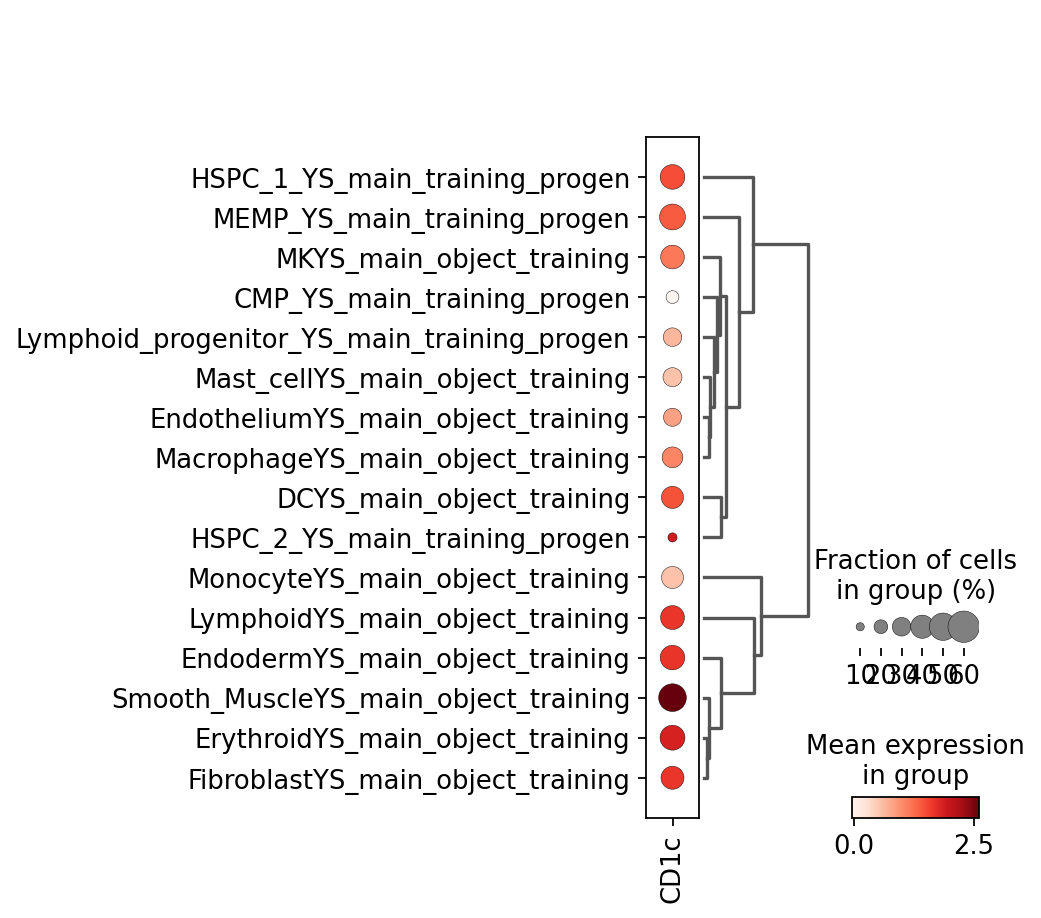

In [16]:
markers = ['CD1c']
sc.pl.dotplot(protein, markers, groupby='work_labels_with_progen_labels_13102021_protein', dendrogram=True)

(array([3.281e+03, 2.030e+02, 3.500e+01, 1.200e+01, 1.500e+01, 7.000e+00,
        3.000e+00, 5.000e+00, 5.000e+00, 3.000e+00]),
 array([-0.41486406,  5.3232317 , 11.061328  , 16.799423  , 22.53752   ,
        28.275616  , 34.01371   , 39.75181   , 45.489902  , 51.228     ,
        56.966095  ], dtype=float32),
 <BarContainer object of 10 artists>)

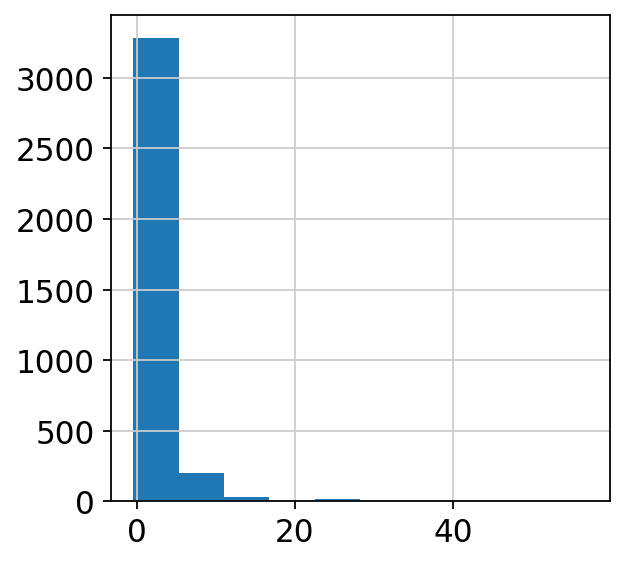

In [17]:
plt.hist(protein.raw[:,protein.raw.var.index.isin(['CD1c'])].X)

(array([3281.,  186.,   40.,   17.,    4.,   13.,    7.,    5.,    4.,
          12.]),
 array([-0.09296855,  0.9163283 ,  1.9256252 ,  2.934922  ,  3.9442189 ,
         4.9535155 ,  5.9628124 ,  6.9721093 ,  7.981406  ,  8.990704  ,
        10.        ], dtype=float32),
 <BarContainer object of 10 artists>)

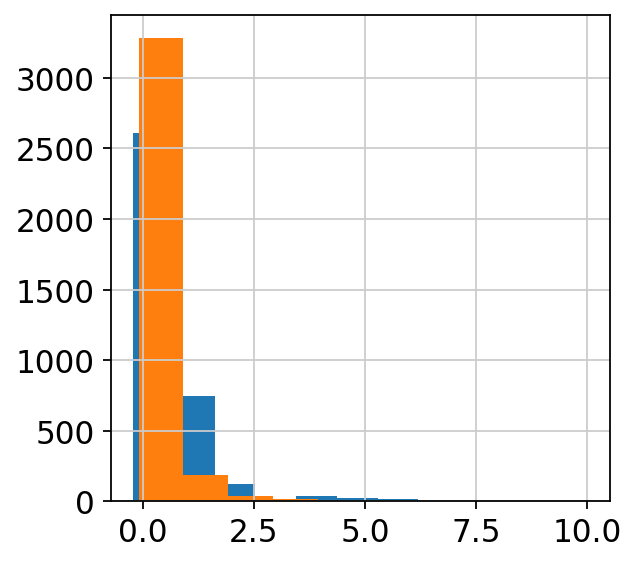

In [18]:
plt.hist(protein[:,protein.var.index.isin(['CD301_protein'])].X.toarray())
plt.hist(protein[:,protein.var.index.isin(['CD1c_protein'])].X.toarray())

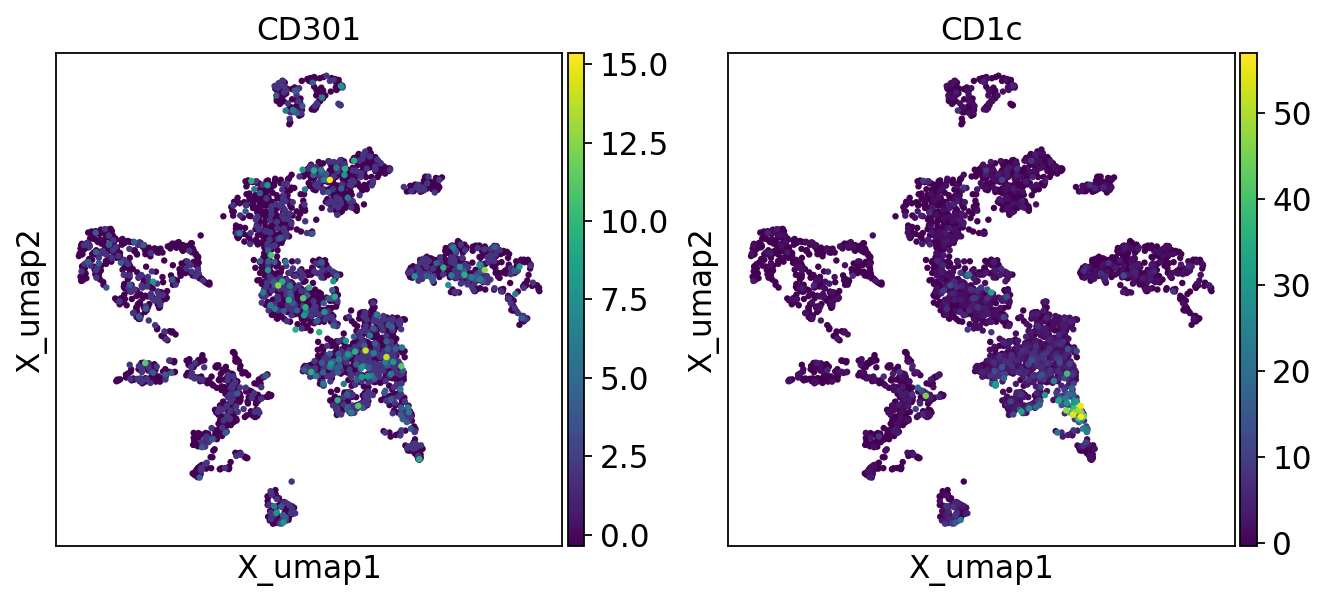

In [19]:
sc.pl.embedding(protein, 'X_umap', color=['CD301','CD1c'], gene_symbols=None, use_raw=None, sort_order=True, edges=False, edges_width=0.1, edges_color='grey', neighbors_key=None, arrows=False, arrows_kwds=None, groups=None, components=None, layer=None, projection='2d',  size=None, frameon=None, legend_fontsize=None, legend_fontweight='bold', legend_loc='right margin')

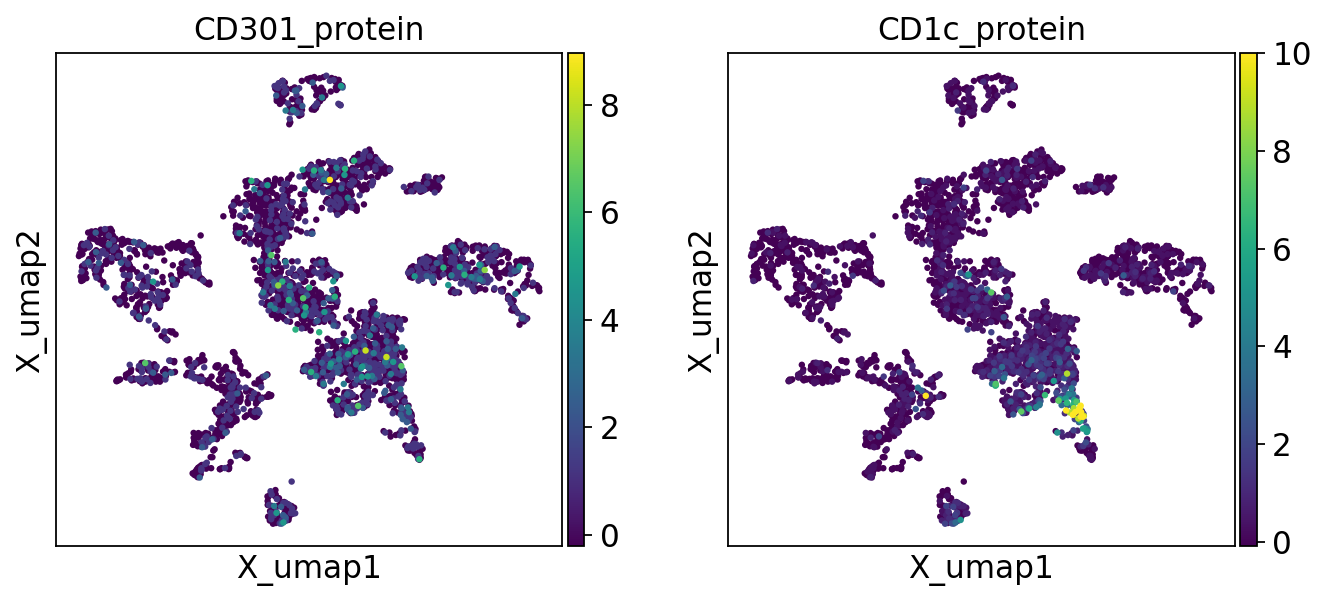

In [20]:
sc.pl.embedding(adata, 'X_umap', color=['CD301_protein','CD1c_protein'], gene_symbols=None, use_raw=None, sort_order=True, edges=False, edges_width=0.1, edges_color='grey', neighbors_key=None, arrows=False, arrows_kwds=None, groups=None, components=None, layer=None, projection='2d',  size=None, frameon=None, legend_fontsize=None, legend_fontweight='bold', legend_loc='right margin')

In [665]:
adata.write('/nfs/team205/ig7/resources/scripts_dont_modify/cite_seq/Objects_for_bertie_meeting_14102021/protein_rna_combined_cite_seq.h5ad')

# Secondary PCA and umap (optional)--use pre-scaled data for each set

In [377]:
adata.raw = adata[:]

In [ ]:
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4)
#sc.pp.scale(adata, zero_center=False, max_value=None, copy=False) #zero_center=True (densifies output)

# Now compute PCA
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=50)


# Batch correction options
# The script will test later which Harmony values we should use
if (batch_correction == "False"):
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)    
if(batch_correction == "Harmony"):
    print("Commencing harmony")
    # Create hm subset
    adata_hm = adata[:]
    # Set harmony variables
    data_mat = np.array(adata_hm.obsm["X_pca"])
    meta_data = adata_hm.obs
    vars_use = [batch_var]
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use,theta=3)
    res = (pd.DataFrame(ho.Z_corr)).T
    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
    # Insert coordinates back into object
    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
    adata_hm.obsm["X_pca"] = np.array(res)
    # Run neighbours
    sc.pp.neighbors(adata_hm, n_neighbors=15, n_pcs=50)
    adata = adata_hm[:]
    del adata_hm
elif(batch_correction == "BBKNN"):
    print("Commencing BBKNN")
    sc.external.pp.bbknn(adata, batch_key=batch_var, approx=True, metric='angular', copy=False, n_pcs=50, trim=None, n_trees=10, use_faiss=True, set_op_mix_ratio=1.0, local_connectivity=15) 
sc.tl.umap(adata)
adata.obsm['X_umap_rna'] = rna.obsm['X_umap']
adata.obsm['X_umap_rna_protein'] = adata.obsm['X_umap']

In [ ]:
adata.obs

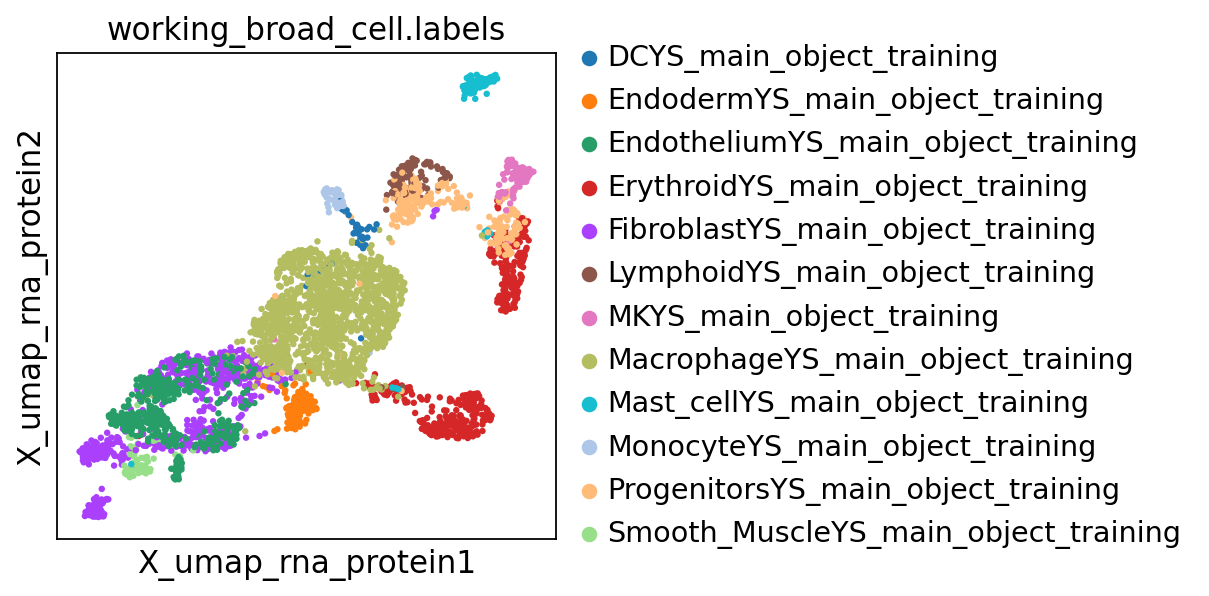

In [355]:
sc.pl.embedding(adata, 'X_umap_rna_protein', color='working_broad_cell.labels', gene_symbols=None, use_raw=None, sort_order=True, edges=False, edges_width=0.1, edges_color='grey', neighbors_key=None, arrows=False, arrows_kwds=None, groups=None, components=None, layer=None, projection='2d',  size=None, frameon=None, legend_fontsize=None, legend_fontweight='bold', legend_loc='right margin')

# Update data with new protein/rna

In [219]:
protein = sc.read(protein_path)
# Rename Protein var_names to make unique classes
protein.var['protein_var'] = protein.var.index
protein.var['feature_types'] = 'protein'
protein.var.index = protein.var.index.astype(str) + '_protein'

# Load in rna data

In [220]:
rna = sc.read(rna_path)
rna.obs['new_index'] = rna.obs.index.str.replace('-1-SIGAG5-SIGAG5','-SIGAD11',regex=True)
rna.obs['new_index'] = rna.obs['new_index'].str.replace('-1-SIGAH5-SIGAH5','-SIGAE11',regex=True)
rna.obs.index = rna.obs['new_index']
del rna.obs['new_index']
rna.obs.index.name = ''

# Creation of combination data

In [221]:
protein = protein[protein.obs.index.isin(rna.obs.index)]
rna = rna[rna.obs.index.isin(protein.obs.index)]
protein_obs = protein.obs
protein_obs.columns = protein_obs.columns.astype(str) + '_protein'
obs = pd.concat([rna.obs, protein_obs], axis=1)

In [222]:
obs

,identifier,sequencing.type,souporcell_doublet,souporcell_assignment,orig.ident,sex,sex_auto_assign,mad_prd,auto_prd,is_doublet,...,scrublet_score,scrublet_cluster_score,scr_bh_pval,scr_pval,new_doublets,new_doublets_bh,scr_doublet_call_default,scrublet_leiden_R,Identifier_protein,working_broad_cell.labels_protein
AAACGAAGTTCTTAGG-SIGAE11,SIGAH5,3prime,singlet,0,Sample_0,Female,Female,False,False,False,...,0.058824,0.069879,0.980645,0.884962,False,False,False,1_2,SIGAE11,MacrophageYS_main_object_training
AAACGCTAGGACTGGT-SIGAE11,SIGAH5,3prime,singlet,0,Sample_0,Female,Female,False,False,False,...,0.033248,0.045845,0.980645,0.971510,False,False,False,15_1,SIGAE11,ErythroidYS_main_object_training
AAACGCTCATCACAGT-SIGAE11,SIGAH5,3prime,singlet,0,Sample_0,Female,Female,True,False,True,...,0.098039,0.040853,0.980645,0.979795,False,False,False,1_0,SIGAE11,MacrophageYS_main_object_training
AAACGCTGTATACCCA-SIGAE11,SIGAH5,3prime,singlet,0,Sample_0,Female,Female,False,False,False,...,0.055644,0.053826,0.980645,0.952533,False,False,False,20_0,SIGAE11,MacrophageYS_main_object_training
AAACGCTTCTAACGCA-SIGAE11,SIGAH5,3prime,singlet,0,Sample_0,Female,Female,False,False,False,...,0.104072,0.065657,0.980645,0.907202,False,False,False,0_0,SIGAE11,FibroblastYS_main_object_training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACTGATTG-SIGAD11,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,False,False,False,...,0.093023,0.080426,0.952702,0.536254,False,False,False,2_0,SIGAD11,MacrophageYS_main_object_training
TTTGTTGCAGCTGTGC-SIGAD11,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,False,False,False,...,0.122970,0.088186,0.952702,0.448687,False,False,False,5_1,SIGAD11,MacrophageYS_main_object_training
TTTGTTGGTAATGTGA-SIGAD11,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,True,False,True,...,0.058296,0.076888,0.952702,0.575861,False,False,False,4_3,SIGAD11,EndotheliumYS_main_object_training
TTTGTTGGTCAGTCCG-SIGAD11,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,False,False,False,...,0.038509,0.061191,0.952702,0.737705,False,False,False,3_4,SIGAD11,FibroblastYS_main_object_training


In [287]:
protein.obs

,Identifier_protein,working_broad_cell.labels_protein,identifier_protein,sequencing.type_protein,souporcell_doublet_protein,souporcell_assignment_protein,orig.ident_protein,sex_protein,sex_auto_assign_protein,mad_prd_protein,...,scrublet_cluster_score_protein,scr_bh_pval_protein,scr_pval_protein,new_doublets_protein,new_doublets_bh_protein,scr_doublet_call_default_protein,scrublet_leiden_R_protein,X_UMAP_1_protein,X_UMAP_2_protein,work_labels_with_progen_labels_13102021_protein
AGGTTACAGTATGACA-SIGAD11,SIGAD11,MacrophageYS_main_object_training,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,False,...,0.022381,0.958760,0.958760,False,False,False,1_4,6.293653,1.877747,MacrophageYS_main_object_training
TACGGTAAGAATAGTC-SIGAD11,SIGAD11,ErythroidYS_main_object_training,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,False,...,0.120857,0.952702,0.145680,False,False,False,6_0,-3.915667,5.542274,ErythroidYS_main_object_training
AGACACTAGAGGGTAA-SIGAD11,SIGAD11,MKYS_main_object_training,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,False,...,0.129642,0.952702,0.096085,False,False,False,14_3,-1.144533,-3.408243,MKYS_main_object_training
CTAACTTCAATAGGGC-SIGAD11,SIGAD11,EndotheliumYS_main_object_training,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,True,...,0.086670,0.952702,0.465734,False,False,False,4_1,16.156683,3.681108,EndotheliumYS_main_object_training
GTTACCCGTTCTTGCC-SIGAD11,SIGAD11,EndotheliumYS_main_object_training,SIGAG5,3prime,singlet,0,Sample_0,Female,Female,False,...,0.068573,0.952702,0.665315,False,False,False,4_4,13.464068,4.859620,EndotheliumYS_main_object_training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TACGTCCCACTCCGAG-SIGAE11,SIGAE11,FibroblastYS_main_object_training,SIGAH5,3prime,singlet,0,Sample_0,Female,Female,False,...,0.069774,0.980645,0.885559,False,False,False,3_0,8.913760,9.345469,FibroblastYS_main_object_training
ATGTCTTTCGCCACTT-SIGAE11,SIGAE11,EndodermYS_main_object_training,SIGAH5,3prime,doublet,0/1,Unassigned,Female,Unassigned,True,...,0.071668,0.980645,0.874474,False,False,False,8_1,9.005548,17.676407,EndodermYS_main_object_training
GACTTCCAGTATGGCG-SIGAE11,SIGAE11,ErythroidYS_main_object_training,SIGAH5,3prime,singlet,1,Sample_1,Female,Female,False,...,0.114460,0.980645,0.458423,False,False,False,25_2,-1.205055,5.916661,ErythroidYS_main_object_training
TCAGCCTTCTCGCTCA-SIGAE11,SIGAE11,EndodermYS_main_object_training,SIGAH5,3prime,singlet,0,Sample_0,Female,Female,False,...,0.071668,0.980645,0.874474,False,False,False,8_1,9.238972,18.015726,EndodermYS_main_object_training


In [ ]:
protein = protein[protein.obs.index.isin(rna.obs.index)]
rna = rna[rna.obs.index.isin(protein.obs.index)]
protein_obs = protein.obs
protein_obs.columns = protein_obs.columns.astype(str) + '_protein'
obs = pd.concat([rna.obs, protein_obs], axis=1)
print(len(rna.obs))
exp_arr = csr_matrix(scipy.sparse.hstack(((rna.X),(protein.X))))
var = pd.concat([rna.var,protein.var])
uns = rna.uns
obsm = rna.obsm
obs = pd.concat([rna.obs, protein_obs], axis=1)

#varm = rna.varm
obsp = rna.obsp

adata.obs = obs
adata.var = var
adata.uns = uns
#obsm
#adata.obsm['X_umap_rna'] = rna.obsm['X_umap']

In [227]:
adata.obsm['X_umap_rna'] = rna.obsm['X_umap']
adata.obsm['X_umap'] = rna.obsm['X_umap']
adata.obsm['X_umap_protein_rna'] = adata.obsm['X_umap']

In [249]:
var = adata.var.apply(str)
pd.DataFrame(var)

,0
gene_ids,MIR1302-2HG ENSG00000243485\nFAM138A ...
feature_types,MIR1302-2HG Gene Expression\nFAM138A ...
highly_variable,MIR1302-2HG False\nFAM138A ...
means,MIR1302-2HG 1.000000e-12\nFAM138A ...
dispersions,MIR1302-2HG NaN\nFAM138A ...
dispersions_norm,MIR1302-2HG 0.000000\nFAM138A ...
mean,MIR1302-2HG 0.000000\nFAM138A ...
std,MIR1302-2HG 1.000000\nFAM138A ...
protein_var,MIR1302-2HG NaN\nFAM138A ...


In [254]:
adata.var.columns

Index(['gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions',
       'dispersions_norm', 'mean', 'std', 'protein_var'],
      dtype='object')

In [256]:
adata.var = adata.var[['gene_ids', 'feature_types', 'means', 'dispersions',
       'dispersions_norm', 'mean', 'std', 'protein_var']]

In [318]:
adata.obs['work_labels_with_progen_labels_13102021_protein'] = protein_meta['work_labels_with_progen_labels_13102021']
adata.obs['working_broad_cell.labels_protein'] = protein_meta['working_broad_cell.labels']
adata.obs['working_broad_cell.labels_protein']

AAACGAAGTTCTTAGG-SIGAE11     MacrophageYS_main_object_training
AAACGCTAGGACTGGT-SIGAE11      ErythroidYS_main_object_training
AAACGCTCATCACAGT-SIGAE11     MacrophageYS_main_object_training
AAACGCTGTATACCCA-SIGAE11     MacrophageYS_main_object_training
AAACGCTTCTAACGCA-SIGAE11     FibroblastYS_main_object_training
                                           ...                
TTTGTTGCACTGATTG-SIGAD11     MacrophageYS_main_object_training
TTTGTTGCAGCTGTGC-SIGAD11     MacrophageYS_main_object_training
TTTGTTGGTAATGTGA-SIGAD11    EndotheliumYS_main_object_training
TTTGTTGGTCAGTCCG-SIGAD11     FibroblastYS_main_object_training
TTTGTTGGTGGGTTGA-SIGAD11     MacrophageYS_main_object_training
Name: working_broad_cell.labels_protein, Length: 3569, dtype: object

In [289]:
protein_meta = pd.read_csv('/nfs/team205/ig7/resources/scripts_dont_modify/cite_seq/protein_object_progen_anno_13102021.csv',index_col = 0)

In [ ]:
adata = adata[adata.obs.index.isin(protein_meta.index)]
adata.obsm["X_umap_protein"] = protein_meta[['X_UMAP_1','X_UMAP_2']].values

In [322]:
adata.obsm

AxisArrays with keys: X_orig_pca, X_pca, X_umap, X_umap_rna, X_pca_back, X_umap_protein_rna, X_umap_protein

In [346]:
adata.obsm['X_umap_protein'] = np.array(adata.obsm['X_umap_protein'])

In [347]:
adata.obsm['X_umap_protein_rna'] = np.array(adata.obsm['X_umap_protein_rna'])

In [349]:
(adata.obsm['X_umap_rna']) = np.array(adata.obsm['X_umap_rna'])

In [321]:
np.array(adata.obsm['X_umap'])

array([[ 4.851627  ,  5.875533  ],
       [ 0.64011997,  6.111692  ],
       [ 8.123862  ,  1.7660241 ],
       ...,
       [14.937441  ,  5.045345  ],
       [ 7.886389  , 12.066126  ],
       [12.159487  , -1.5464312 ]], dtype=float32)

In [356]:
adata.write('/nfs/team205/ig7/resources/scripts_dont_modify/cite_seq/Objects_for_bertie_meeting_14102021/protein_rna_combined_cite_seq.h5ad')

In [344]:
protein.obsm['X_umap'] = np.array(protein.obsm['X_umap'])
protein.obsm['X_umap']

array([[ 6.29365253,  1.87774694],
       [-3.9156673 ,  5.54227352],
       [-1.14453256, -3.4082427 ],
       ...,
       [-1.20505452,  5.91666126],
       [ 9.23897171, 18.01572609],
       [12.67956924, -2.17896962]])

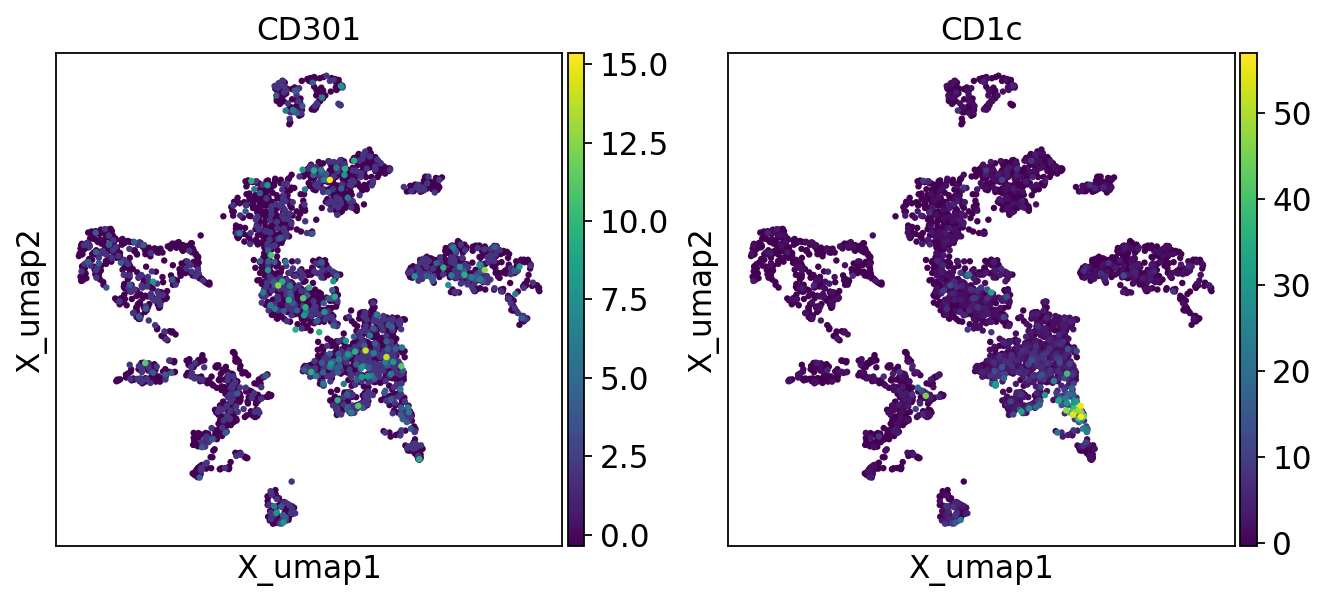

In [432]:
sc.pl.embedding(protein, 'X_umap', color=['CD301','CD1c'], gene_symbols=None, use_raw=None, sort_order=True, edges=False, edges_width=0.1, edges_color='grey', neighbors_key=None, arrows=False, arrows_kwds=None, groups=None, components=None, layer=None, projection='2d',  size=None, frameon=None, legend_fontsize=None, legend_fontweight='bold', legend_loc='right margin')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'gene_ids' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated

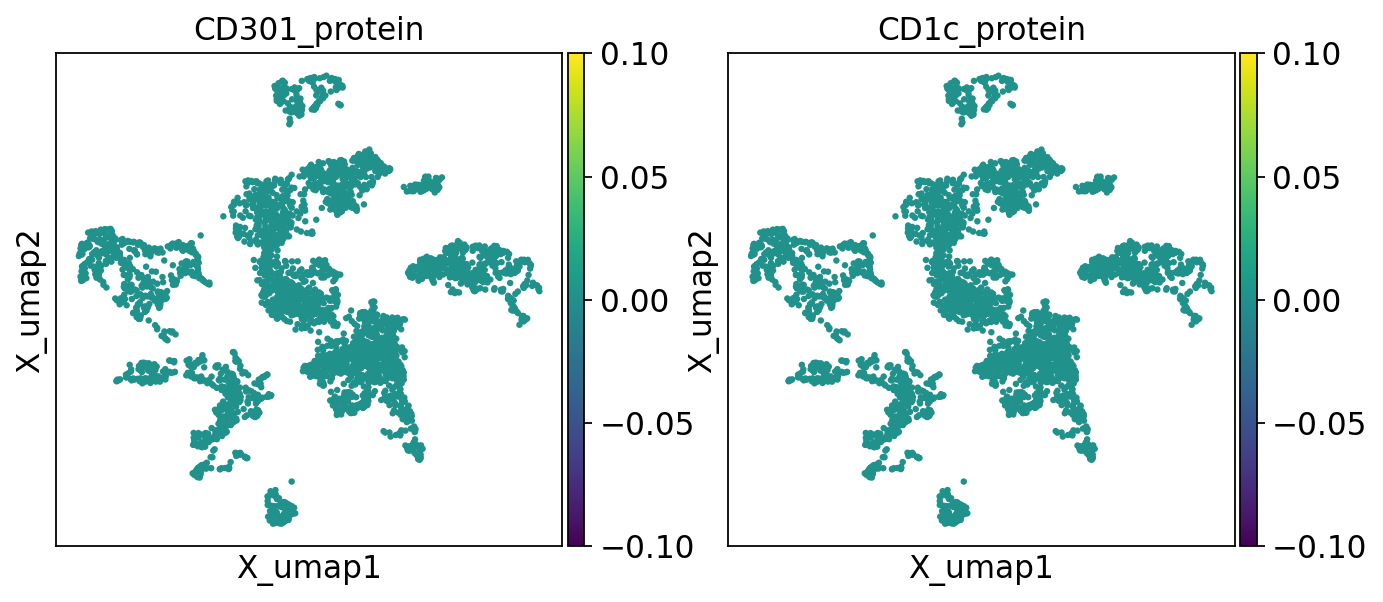

In [431]:
sc.pl.embedding(adata, 'X_umap', color=['CD301_protein','CD1c_protein'], gene_symbols=None, use_raw=None, sort_order=True, edges=False, edges_width=0.1, edges_color='grey', neighbors_key=None, arrows=False, arrows_kwds=None, groups=None, components=None, layer=None, projection='2d',  size=None, frameon=None, legend_fontsize=None, legend_fontweight='bold', legend_loc='right margin')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical


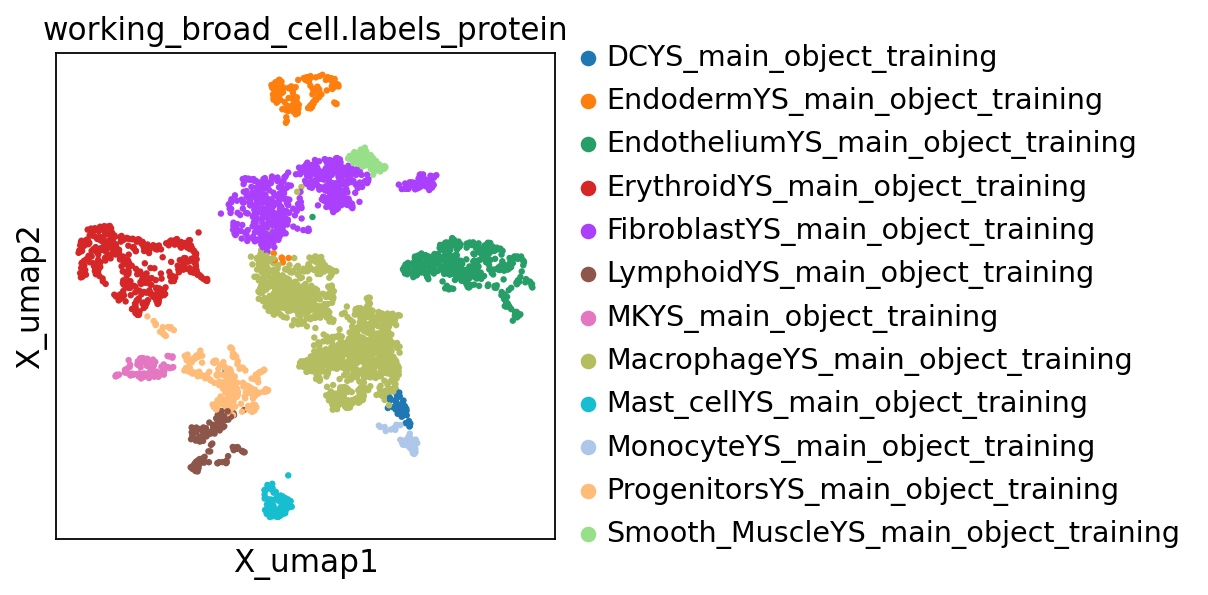

In [401]:
sc.pl.embedding(protein, 'X_umap', color='working_broad_cell.labels_protein', gene_symbols=None, use_raw=None, sort_order=True, edges=False, edges_width=0.1, edges_color='grey', neighbors_key=None, arrows=False, arrows_kwds=None, groups=None, components=None, layer=None, projection='2d',  size=None, frameon=None, legend_fontsize=None, legend_fontweight='bold', legend_loc='right margin')